# Simulation Result Analysor

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

sns.set_style("ticks")
font = {
    "font.family": "DejaVu Sans",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 3,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.8, rc=paper_rc)
current_palette = sns.color_palette()

pd.set_option("display.max_columns", None)
cmp = sns.color_palette("tab10")
color_list = [cmp[7], cmp[1], cmp[2], cmp[4], cmp[-1], cmp[6]]


# policy_dict = {"fifo": "FIFO", "sjf": "SJF", "qssf": "QSSF", "tiresias": "Tiresias", "lucid": "Lucid", "lucid-alwaysgpu":"Lucid-alwaysgpu"}

# policy_dict = {"lucid":"lucid","lucid-alwaysgpu":"lucid-alwaysgpu", "lucid-node-scale-0":"lucid-node-scale-0", "lucid-node-scale-2":"lucid-node-scale-2","lucid-node-scale-3":"lucid-node-scale-3", "lucid-node-scale-4":"lucid-node-scale-4"}
#
# policy_dict = {"lucid":"lucid","lucid-alwaysgpu":"lucid-alwaysgpu"}
policy_dict = {"lucid":"lucid","lucid-alwaysgpu":"lucid-alwaysgpu", "lucid-nogpu":"lucid-nogpu"}


policy_list = list(policy_dict.values())
policy_list_lower = list(policy_dict.keys())
cluster_list = ["Venus", "Saturn", "Philly"]
experiment_list = ["Venus_Sept", "Saturn_Sept", "Philly"]

# experiment_list = ["Venus_Sept_all", "Saturn_Sept", "Philly"]

save = True
experiment_name = experiment_list[0]

log_base_dir = "../log/vc_node_factor_1.2"
# log_base_dir = "../log"
log_dir = f"{log_base_dir}/{experiment_name}"

# log_dir = f"../log/{experiment_name}"
placer = "consolidate"
cluster = experiment_name.split("_")[0]

jct_avg = pd.read_csv(f"{log_dir}/jct_avg_{placer}.csv", index_col=0)
que_avg = pd.read_csv(f"{log_dir}/que_avg_{placer}.csv", index_col=0)


def process_summary(df):
    all_df = df.loc[["all"]]
    df = df.drop(index="all")
    df.sort_values(by="fifo_consolidate", ascending=False, inplace=True)
    df = df.head(10)
    df = pd.concat([df, all_df])

    if "srtf_consolidate" in df.columns:
        df = df.drop(columns="srtf_consolidate")

    # exchange tiresias and lucid
    cols = [x + f'_{placer}' for x in policy_list_lower]
    # cols[-1], cols[-2] = cols[-2], cols[-1]
    df = df.reindex(columns=cols)
    return df

## Table 4: Result Summary

In [8]:
jct = pd.DataFrame() # Average JCT
que = pd.DataFrame() # Average Queuing Delay
quetail = pd.DataFrame() # Queuing Delay Quantile

pair_rate = pd.DataFrame() # Pair rate

for experiment_name in ["Venus_Sept"]:
    cluster = experiment_name.split('_')[0]
    for policy in policy_list:
        log = pd.read_csv(f'{log_dir}/all/{policy.lower()}_consolidate_all_log.csv')
        jct.at[policy, cluster] = log['jct'].mean()
        que.at[policy, cluster] = log['queue'].mean()
        quetail.at[policy, cluster] = log['queue'].quantile(q=0.999)
        
        pair_rate.at[policy, cluster] = 1 - log['exclusive'].sum() / log['exclusive'].count()
        # pair_rate.at[policy, cluster] = log['exclusive'].sum() 
        # pair_rate.at[policy, cluster] = log['exclusive'].count()

print("Average JCT")
print(jct.astype(int))
print("\nAverage Queuing Delay")
print(que.astype(int))
print("\nQueuing Delay 99.9 Quantile")
print(quetail.astype(int))

print("\nPair Rate")
print(pair_rate.astype(float))

jct = pd.concat([jct, que, quetail])
jct = jct.astype(int)
jct.to_csv('result_summary.csv')

Average JCT
                 Venus
lucid            12676
lucid-alwaysgpu  12434
lucid-nogpu      12863

Average Queuing Delay
                 Venus
lucid              938
lucid-alwaysgpu    486
lucid-nogpu       1144

Queuing Delay 99.9 Quantile
                 Venus
lucid            98664
lucid-alwaysgpu  66564
lucid-nogpu      98744

Pair Rate
                    Venus
lucid            0.022968
lucid-alwaysgpu  0.149168
lucid-nogpu      0.000000


## Table 5: Result Summary of Different Scales of Workloads

In [4]:
jct = pd.DataFrame()  # Average JCT
que = pd.DataFrame()  # Average Queuing Delay

for experiment_name in ["Venus_Sept"]:
    cluster = experiment_name.split("_")[0]
    # for policy in ["fifo", "tiresias", "lucid", "lucid-alwaysgpu"]:
    for policy in policy_list:
        log = pd.read_csv(f"{log_dir}/all/{policy.lower()}_consolidate_all_log.csv")
        jct.at[policy, f"{cluster}(Large)"] = log[log["gpu_num"] > 8]["jct"].mean()
        jct.at[policy, f"{cluster}(Small)"] = log[log["gpu_num"] <= 8]["jct"].mean()
        que.at[policy, f"{cluster}(Large)"] = log[log["gpu_num"] > 8]["queue"].mean()
        que.at[policy, f"{cluster}(Small)"] = log[log["gpu_num"] <= 8]["queue"].mean()

print("Average JCT")
print(jct.astype(int))
print("\nAverage Queuing Delay")
print(que.astype(int))

Average JCT
                 Venus(Large)  Venus(Small)
lucid                 6500990        596294
lucid-alwaysgpu       2779535        548598

Average Queuing Delay
                 Venus(Large)  Venus(Small)
lucid                 6366491        478942
lucid-alwaysgpu       2645036        433255


## Plot Result 8: JCT

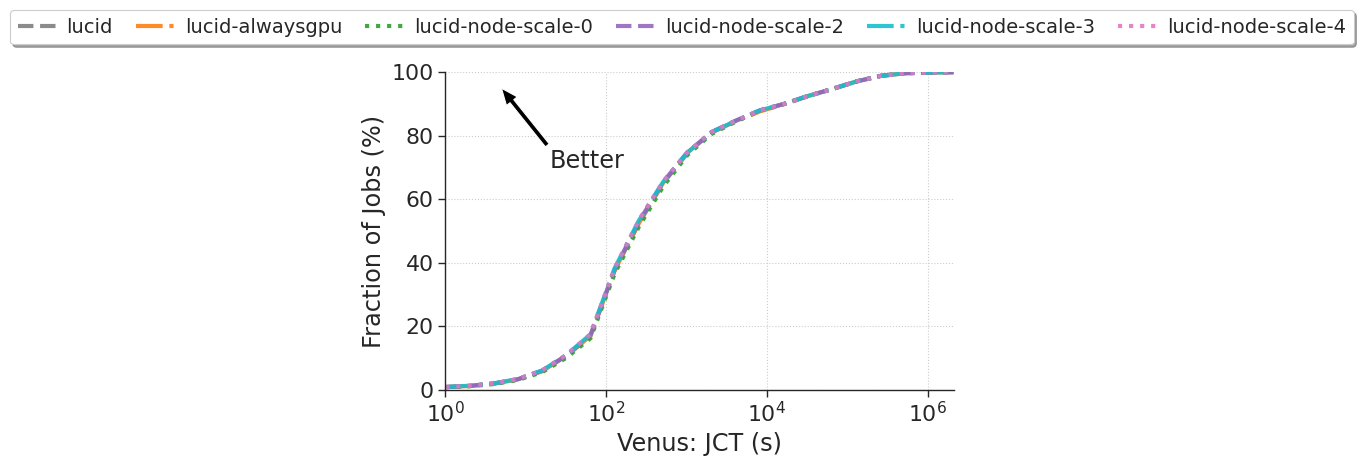

In [14]:
fig, axs = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(6, 4))
axs = [axs]

experiment_list = ["Venus_Sept"]
placer = "consolidate"
cluster_list = ["Venus"]
linestyles = ["--", "-.", ":", "--", "-.", ":"]

for e in range(0, len(experiment_list)):
    for k in range(0, len(policy_list_lower)):
        job_ratio = []
        time = [2**i for i in range(0, 22)]

        log_dir = f"../log/{experiment_list[e]}/all"

        log = pd.read_csv(f"{log_dir}/{policy_list_lower[k]}_{placer}_all_log.csv")

        for t in time:
            job_ratio.append(len(log[log["jct"] <= t]) / len(log) * 100)

        axs[e].plot(time, job_ratio, linestyles[k], alpha=0.9, label=policy_list[k], color=color_list[k])

marks = {0: "a", 1: "b", 2: "c"}
for e in range(1):
    axs[e].set_xscale("log")
    axs[e].set_xlabel(f"{cluster_list[e]}: JCT (s)")
    axs[e].set_ylabel(f"Fraction of Jobs (%)")
    axs[e].set_xlim(1, time[-1])
    axs[e].set_ylim(0, 100)
    axs[e].grid(linestyle=":")

axs[0].annotate("Better", xy=(5, 95), xytext=(20, 70), arrowprops=dict(facecolor="black", width=3.5, headwidth=10))


handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=6,
    bbox_to_anchor=(0.54, 1.15),
    fancybox=True,
    shadow=True,
    fontsize=14,
    handletextpad=0.5,
    columnspacing=1.2,
)
sns.despine()

save = True
if save:
    fig.savefig(f"result_cdf_jct.pdf", bbox_inches="tight")


## Plot Result 9: Queue Time in each VC

In [6]:
from matplotlib.gridspec import GridSpec

jct_avg = [None]*3
que_avg = [None]*3
cluster = [None]*3
cmp = sns.color_palette("tab10")
def read_file(experiment_name):
    log_dir = f"../log/{experiment_name}"
    placer = "consolidate"
    cluster = experiment_name.split("_")[0]

    jct_avg = pd.read_csv(f"{log_dir}/jct_avg_{placer}.csv", index_col=0)
    que_avg = pd.read_csv(f"{log_dir}/que_avg_{placer}.csv", index_col=0)
    jct_avg = process_summary(jct_avg)
    que_avg = process_summary(que_avg)
    return jct_avg, que_avg, cluster

jct_avg[0], que_avg[0], cluster[0] = read_file(experiment_list[0])
que_avg[0].drop(['vcLTP', 'vchA3'], inplace=True)

grid_params=dict(width_ratios=[6, 6, 1])
fig, axs = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(8, 3))
axs = [axs]

width = 0.15
x = np.arange(1, len(que_avg[0]) + 1)
off = width * len(que_avg[0].columns) * 2
labels = []
for c in que_avg[0].columns:
    labels.append(c.split("_")[0])

col_num = len(que_avg[0].columns)
for i in range(col_num):
    offset = i - col_num // 2
    p1 = axs[0].bar(
        x + offset * width,
        que_avg[0].iloc[:, i],
        width,
        alpha=0.9,
        linewidth=0.8,
        edgecolor="k",
        label=policy_dict[labels[i]],
        color=color_list[i]
    )

ylabel = f"Average Queuing Time (s)"
axs[0].set_xlabel(f"VC in {cluster[0]}")
axs[0].set_ylabel(ylabel)
# axs[0].set_yscale('log')
axs[0].set_xticks(x)
axs[0].set_xlim(0.3, 9.7)
axs[0].set_ylim(0, 20000)
axs[0].set_xticklabels(que_avg[0].index.values, fontsize=13)
axs[0].ticklabel_format(axis="y", style="sci", scilimits=(-6, 2), useMathText=True)
axs[0].grid(axis="y", linestyle=":")
axs[0].annotate("11", xy=(0.72, 19999), xytext = (0.9, 18000), arrowprops=dict(facecolor='black', width=2, headwidth=6), fontsize=13)
axs[0].annotate("8.0", xy=(1.72, 19999), xytext = (1.9, 18000), arrowprops=dict(facecolor='black', width=2, headwidth=6), fontsize=13)
axs[0].annotate("7.6", xy=(2.72, 19999), xytext = (2.9, 18000), arrowprops=dict(facecolor='black', width=2, headwidth=6), fontsize=13)
axs[0].annotate("2.1", xy=(3.72, 19999), xytext = (3.9, 18000), arrowprops=dict(facecolor='black', width=2, headwidth=6), fontsize=13)
axs[0].annotate("5.5", xy=(8.72, 19999), xytext = (8.9, 18000), arrowprops=dict(facecolor='black', width=2, headwidth=6), fontsize=13)
sns.despine()


handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=6,
    bbox_to_anchor=(0.54, 1.18),
    fancybox=True,
    shadow=True,
    fontsize=14,
    handletextpad=0.5,
    columnspacing=1.2
)
save = True
if save:
    fig.savefig(f"result_bar_queue.pdf", bbox_inches="tight")


KeyError: 'fifo_consolidate'